In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import numpy as np
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_preprocess_data():
    logging.info("Загрузка данных...")
    data = pd.read_csv('Sample - Superstore.csv', encoding='windows-1252')

    logging.info("Удаление ненужных столбцов...")
    data = data.drop(['Row ID', 'Order ID', 'Customer ID', 'Customer Name'], axis=1)

    logging.info("Проверка на пропуски...")
    print("Пропущенные значения до обработки:")
    print(data.isnull().sum())

    def convert_dates(X):
        date_columns = ['Order Date', 'Ship Date']
        for col in date_columns:
            X[col] = pd.to_datetime(X[col], errors='coerce')
            X[col] = (X[col] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')
        return X

    logging.info("Разделение на X и y...")
    X = data.drop('Profit', axis=1)
    y = data['Profit']

    logging.info("Преобразование дат...")
    X = convert_dates(X)

    numeric_imputer = SimpleImputer(strategy='median')
    date_imputer = SimpleImputer(strategy='most_frequent')

    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.drop(['Order Date', 'Ship Date'])
    date_features = ['Order Date', 'Ship Date']
    categorical_features = X.select_dtypes(include=['object']).columns

    logging.info("Создание пайплайна предобработки...")
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', numeric_imputer),
                ('scaler', StandardScaler())
            ]), numeric_features),
            
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features),
            
            ('date', date_imputer, date_features)
        ])

    logging.info("Разделение данных на обучающую и тестовую выборки...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    logging.info("Применение препроцессора...")
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    logging.info("Сохранение препроцессора и данных...")
    joblib.dump(preprocessor, 'preprocessor.joblib')
    joblib.dump({'X_train': X_train, 'X_test': X_test, 
                'y_train': y_train, 'y_test': y_test}, 'preprocessed_data.joblib')

    return X_train, X_test, y_train, y_test

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_and_preprocess_data()
    print("\nПосле обработки:")
    print(f"Размерности данных: Train {X_train.shape}, Test {X_test.shape}")

2025-03-05 14:47:47,544 - INFO - Загрузка данных...
2025-03-05 14:47:47,606 - INFO - Удаление ненужных столбцов...
2025-03-05 14:47:47,609 - INFO - Проверка на пропуски...
2025-03-05 14:47:47,618 - INFO - Разделение на X и y...
2025-03-05 14:47:47,622 - INFO - Преобразование дат...
2025-03-05 14:47:47,650 - INFO - Создание пайплайна предобработки...
2025-03-05 14:47:47,652 - INFO - Разделение данных на обучающую и тестовую выборки...
2025-03-05 14:47:47,658 - INFO - Применение препроцессора...
2025-03-05 14:47:47,774 - INFO - Сохранение препроцессора и данных...


Пропущенные значения до обработки:
Order Date      0
Ship Date       0
Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Product ID      0
Category        0
Sub-Category    0
Product Name    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

После обработки:
Размерности данных: Train (7995, 4252), Test (1999, 4252)


In [2]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
import logging
from datetime import datetime

# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='feature_engineering.log'  # Логирование в файл
)

def create_new_features(data):
    """
    Создание новых признаков.
    """
    logging.info("Создание новых признаков: взаимодействие между Sales и Discount...")
    data['Sales_Discount'] = data['Sales'] * data['Discount']
    
    logging.info("Создание полиномиальных признаков для Sales и Quantity...")
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(data[['Sales', 'Quantity']])
    poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['Sales', 'Quantity']))
    
    logging.info("Создание временных признаков из Order Date...")
    data['Order_Date'] = pd.to_datetime(data['Order Date'])
    data['Order_Day'] = data['Order_Date'].dt.day
    data['Order_Month'] = data['Order_Date'].dt.month
    
    logging.info("Объединение всех признаков...")
    data = pd.concat([data, poly_df], axis=1)
    return data

def preprocess_data_with_new_features(data):
    """
    Предобработка данных с новыми признаками.
    """
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = data.select_dtypes(include=['object']).columns
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

if __name__ == "__main__":
    try:
        logging.info("Загрузка данных...")
        data = pd.read_csv('Sample - Superstore.csv', encoding='windows-1252')
        
        logging.info("Создание новых признаков...")
        data = create_new_features(data)
        
        logging.info("Предобработка данных с новыми признаками...")
        preprocessor = preprocess_data_with_new_features(data)
        
        logging.info("Сохранение предобработанных данных...")
        joblib.dump(preprocessor, 'preprocessor_with_new_features.joblib')
        data.to_csv('data_with_new_features.csv', index=False)
        logging.info("Предобработка завершена успешно.")
    except Exception as e:
        logging.error(f"Ошибка: {str(e)}")

2025-03-05 14:54:44,061 - INFO - Загрузка данных...
2025-03-05 14:54:44,139 - INFO - Создание новых признаков...
2025-03-05 14:54:44,140 - INFO - Создание новых признаков: взаимодействие между Sales и Discount...
2025-03-05 14:54:44,142 - INFO - Создание полиномиальных признаков для Sales и Quantity...
2025-03-05 14:54:44,152 - INFO - Создание временных признаков из Order Date...
2025-03-05 14:54:44,171 - INFO - Объединение всех признаков...
2025-03-05 14:54:44,177 - INFO - Предобработка данных с новыми признаками...
2025-03-05 14:54:44,184 - INFO - Сохранение предобработанных данных...
2025-03-05 14:54:44,419 - INFO - Предобработка завершена успешно.


In [3]:
from data_loader import load_and_preprocess_data
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge, ElasticNet, 
    BayesianRidge, HuberRegressor, OrthogonalMatchingPursuit, 
    PassiveAggressiveRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, 
    GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import joblib
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка предобработанных данных
data_dict = joblib.load('preprocessed_data.joblib')
X_train = data_dict['X_train']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_test = data_dict['y_test']

# Инициализация моделей
models = {
    # Линейные модели
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "Huber Regressor": HuberRegressor(),
    "Orthogonal Matching Pursuit": OrthogonalMatchingPursuit(),
    "Passive Aggressive Regressor": PassiveAggressiveRegressor(max_iter=1000, tol=1e-3),
    
    # Деревья и ансамбли
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    
    # Градиентный бустинг
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    
    # Прочие
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Dummy Regressor": DummyRegressor()
}

# Словарь для результатов
results = {}

# Преобразование в плотные массивы (если необходимо)
def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

# Обучение и оценка
for model_name, model in models.items():
    try:
        logging.info(f"Обучение модели: {model_name}...")
        X_train_dense = to_dense(X_train)
        X_test_dense = to_dense(X_test)
        
        # Кросс-валидация
        cv_scores = cross_val_score(model, X_train_dense, y_train, cv=5, scoring='neg_mean_absolute_error')
        cv_mae = -cv_scores.mean()
        
        model.fit(X_train_dense, y_train)
        y_pred = model.predict(X_test_dense)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[model_name] = {
            "CV MAE": round(cv_mae, 4),
            "MAE": round(mae, 4),
            "MSE": round(mse, 4),
            "RMSE": round(rmse, 4),
            "R²": round(r2, 4)
        }
        
        # Сохранение модели
        joblib.dump(model, f'{model_name.replace(" ", "_").lower()}_model.joblib')
        logging.info(f"[+] {model_name} успешно обучена и сохранена.")
        
    except Exception as e:
        logging.error(f"[!] Ошибка в {model_name}: {str(e)}")

# Вывод результатов
logging.info("\nРезультаты оценки моделей:")
for model_name, metrics in results.items():
    logging.info(f"\n{model_name}:")
    for metric, value in metrics.items():
        logging.info(f"  {metric}: {value}")

2025-03-05 14:57:12,377 - INFO - Обучение модели: Linear Regression...
2025-03-05 15:01:46,583 - INFO - [+] Linear Regression успешно обучена и сохранена.
2025-03-05 15:01:46,584 - INFO - Обучение модели: Lasso...
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.118e+07, tolerance: 2.931e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.123e+07, tolerance: 3.309e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lenovo\AppD

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 6396, number of used features: 131
[LightGBM] [Info] Start training from score 27.559838


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 6396, number of used features: 130
[LightGBM] [Info] Start training from score 32.399711


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 6396, number of used features: 133
[LightGBM] [Info] Start training from score 30.245358


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6396, number of used features: 128
[LightGBM] [Info] Start training from score 31.167953


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 6396, number of used features: 133
[LightGBM] [Info] Start training from score 32.114420


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-05 17:21:42,058 - INFO - [+] LightGBM успешно обучена и сохранена.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 7995, number of used features: 146
[LightGBM] [Info] Start training from score 30.697456


2025-03-05 17:21:42,059 - INFO - Обучение модели: CatBoost...
2025-03-05 17:26:35,178 - INFO - [+] CatBoost успешно обучена и сохранена.
2025-03-05 17:26:35,180 - INFO - Обучение модели: K-Nearest Neighbors...
2025-03-05 17:26:48,218 - INFO - [+] K-Nearest Neighbors успешно обучена и сохранена.
2025-03-05 17:26:48,219 - INFO - Обучение модели: Dummy Regressor...
2025-03-05 17:26:49,068 - INFO - [+] Dummy Regressor успешно обучена и сохранена.
2025-03-05 17:26:49,075 - INFO - 
Результаты оценки моделей:
2025-03-05 17:26:49,078 - INFO - 
Linear Regression:
2025-03-05 17:26:49,081 - INFO -   CV MAE: 72.5048
2025-03-05 17:26:49,082 - INFO -   MAE: 75.1254
2025-03-05 17:26:49,083 - INFO -   MSE: 114285.8541
2025-03-05 17:26:49,085 - INFO -   RMSE: 338.0619
2025-03-05 17:26:49,087 - INFO -   R²: -1.3571
2025-03-05 17:26:49,087 - INFO - 
Lasso:
2025-03-05 17:26:49,089 - INFO -   CV MAE: 54.1109
2025-03-05 17:26:49,093 - INFO -   MAE: 64.8076
2025-03-05 17:26:49,098 - INFO -   MSE: 80484.0657


In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
import logging
import numpy as np

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка данных
data_dict = joblib.load('preprocessed_data.joblib')
X_train = data_dict['X_train']
y_train = data_dict['y_train']

# Модели и их гиперпараметры для оптимизации
models = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'num_leaves': [31, 50, 100]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(random_state=42, verbose=0),
        "params": {
            'iterations': [500, 1000, 1500],
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [1, 3, 5]
        }
    }
}

# Оптимизация гиперпараметров с использованием RandomizedSearchCV
for model_name, config in models.items():
    logging.info(f"Оптимизация гиперпараметров для модели: {model_name}...")
    random_search = RandomizedSearchCV(
        estimator=config["model"],
        param_distributions=config["params"],
        n_iter=20,  # Количество итераций
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    
    # Сохранение лучшей модели
    best_model = random_search.best_estimator_
    joblib.dump(best_model, f'optimized_{model_name.replace(" ", "_").lower()}_model.joblib')
    logging.info(f"Лучшие параметры для {model_name}: {random_search.best_params_}")
    logging.info(f"Лучшая модель сохранена как 'optimized_{model_name.replace(' ', '_').lower()}_model.joblib'")

2025-03-05 17:26:49,436 - INFO - Оптимизация гиперпараметров для модели: Random Forest...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-03-05 19:44:12,160 - INFO - Лучшие параметры для Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
2025-03-05 19:44:12,161 - INFO - Лучшая модель сохранена как 'optimized_random_forest_model.joblib'
2025-03-05 19:44:12,162 - INFO - Оптимизация гиперпараметров для модели: Gradient Boosting...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-03-05 19:45:40,220 - INFO - Лучшие параметры для Gradient Boosting: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}
2025-03-05 19:45:40,221 - INFO - Лучшая модель сохранена как 'optimized_gradient_boosting_model.joblib'
2025-03-05 19:45:40,221 - INFO - Оптимизация гиперпараметров для модели: XGBoost...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-03-05 19:45:54,001 - INFO - Лучшие параметры для XGBoost: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
2025-03-05 19:45:54,002 - INFO - Лучшая модель сохранена как 'optimized_xgboost_model.joblib'
2025-03-05 19:45:54,003 - INFO - Оптимизация гиперпараметров для модели: LightGBM...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-03-05 19:46:02,053 - INFO - Лучшие параметры для LightGBM: {'num_leaves': 50, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
2025-03-05 19:46:02,054 - INFO - Лучшая модель сохранена как 'optimized_lightgbm_model.joblib'
2025-03-05 19:46:02,054 - INFO - Оптимизация гиперпараметров для модели: CatBoost...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 7995, number of used features: 146
[LightGBM] [Info] Start training from score 30.697456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

2025-03-05 19:55:07,172 - INFO - Лучшие параметры для CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1500, 'depth': 8}
2025-03-05 19:55:07,173 - INFO - Лучшая модель сохранена как 'optimized_catboost_model.joblib'


In [10]:
import logging
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("stacking.log"), logging.StreamHandler()]
)

# Пример данных
np.random.seed(42)
X, y = np.random.rand(10000, 100), np.random.rand(10000)

# Преобразование в pandas.DataFrame с именами признаков
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
y = pd.Series(y)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Базовые модели
base_models = [
    ('lgbm', LGBMRegressor(n_estimators=100, max_depth=5, n_jobs=2)),  # Уменьшено n_jobs
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=2))  # Уменьшено n_jobs
]

# Мета-модель
meta_model = LinearRegression()

# Стекинг
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    n_jobs=2  # Уменьшено количество ядер
)

# Оценка стекинга с помощью кросс-валидации
logging.info("Оценка стекинга с помощью кросс-валидации...")
y_pred_cv = cross_val_predict(stacking_model, X_train, y_train, cv=5, n_jobs=2)
mae_cv = mean_absolute_error(y_train, y_pred_cv)
logging.info(f"Средний MAE на кросс-валидации: {mae_cv:.4f}")

# Обучение стекинга на всех данных
logging.info("Обучение стекинга моделей...")
stacking_model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
logging.info("Прогнозирование на тестовой выборке...")
y_pred = stacking_model.predict(X_test)

# Оценка качества на тестовой выборке
mae_test = mean_absolute_error(y_test, y_pred)
logging.info(f"MAE на тестовой выборке: {mae_test:.4f}")

2025-03-05 21:54:22,888 - INFO - Оценка стекинга с помощью кросс-валидации...
2025-03-05 21:59:21,226 - INFO - Средний MAE на кросс-валидации: 0.2495
2025-03-05 21:59:21,228 - INFO - Обучение стекинга моделей...
2025-03-05 22:00:42,265 - INFO - Прогнозирование на тестовой выборке...
2025-03-05 22:00:42,329 - INFO - MAE на тестовой выборке: 0.2528


2025-03-05 21:45:25,117 - INFO - Анализ остатков для модели: Linear Regression...


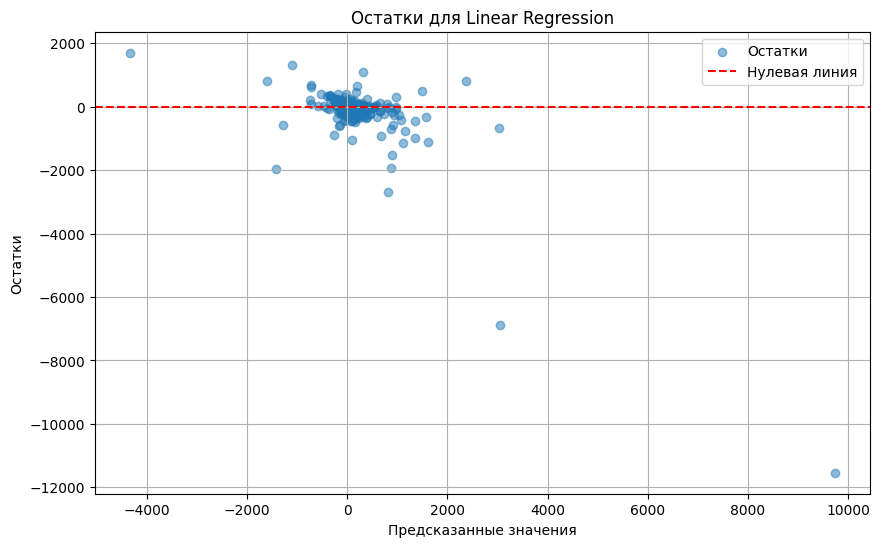

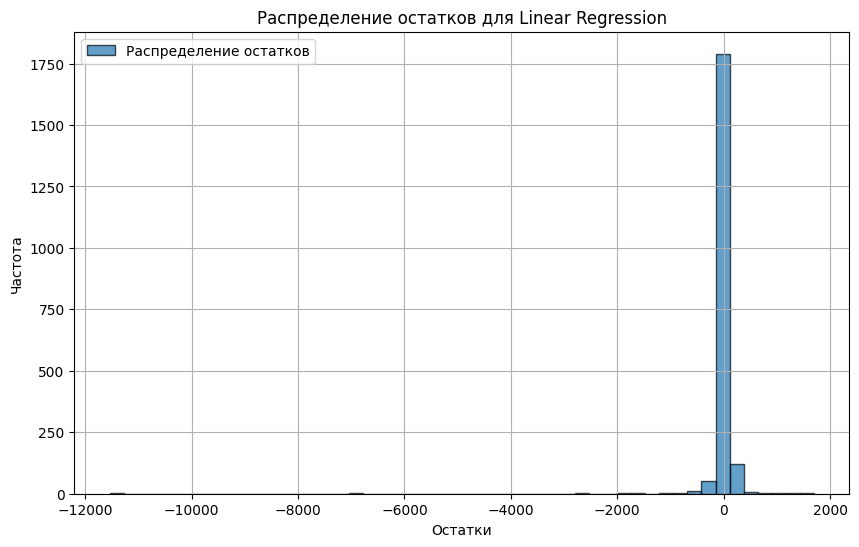

2025-03-05 21:45:25,715 - INFO - Остатки для модели Linear Regression сохранены.
2025-03-05 21:45:25,718 - INFO - Анализ остатков для модели: Random Forest...


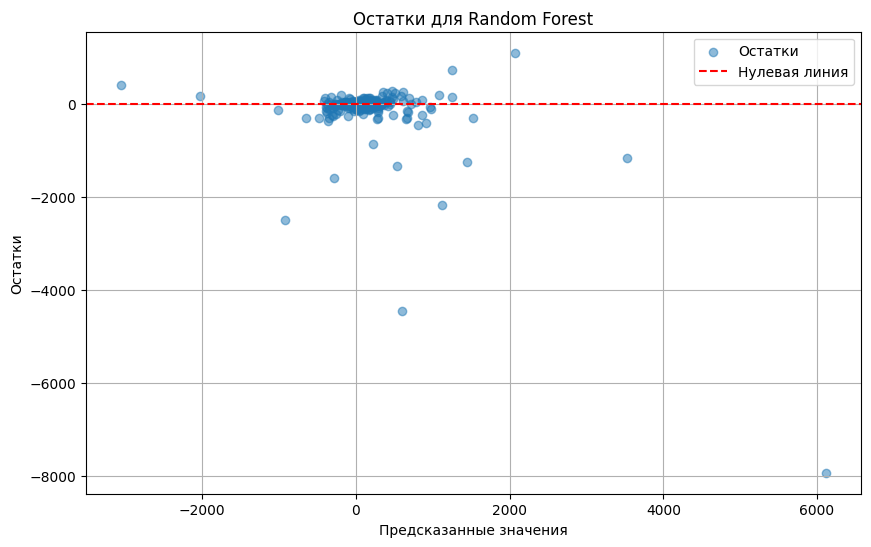

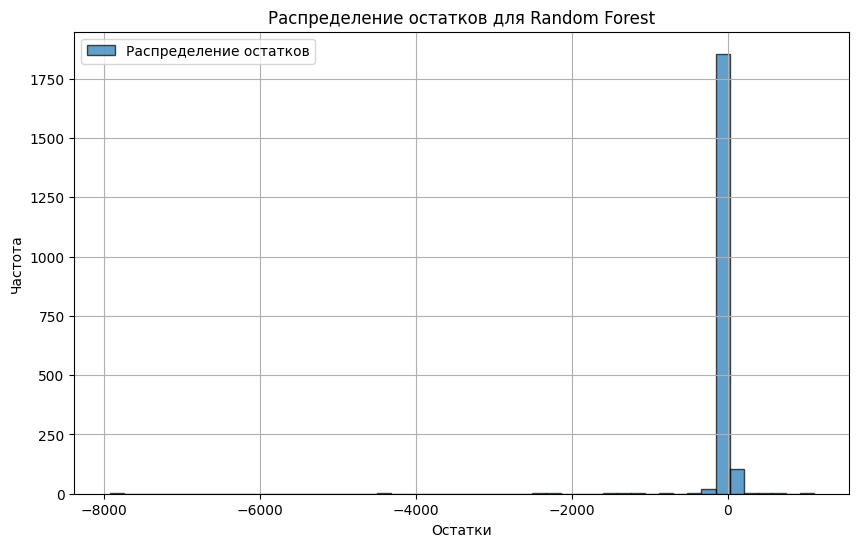

2025-03-05 21:45:26,323 - INFO - Остатки для модели Random Forest сохранены.
2025-03-05 21:45:26,324 - INFO - Анализ остатков для модели: Gradient Boosting...


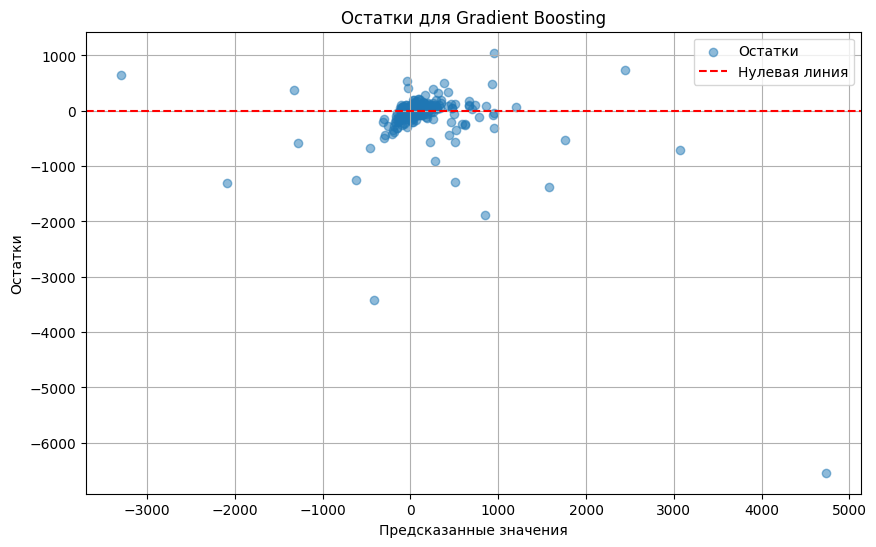

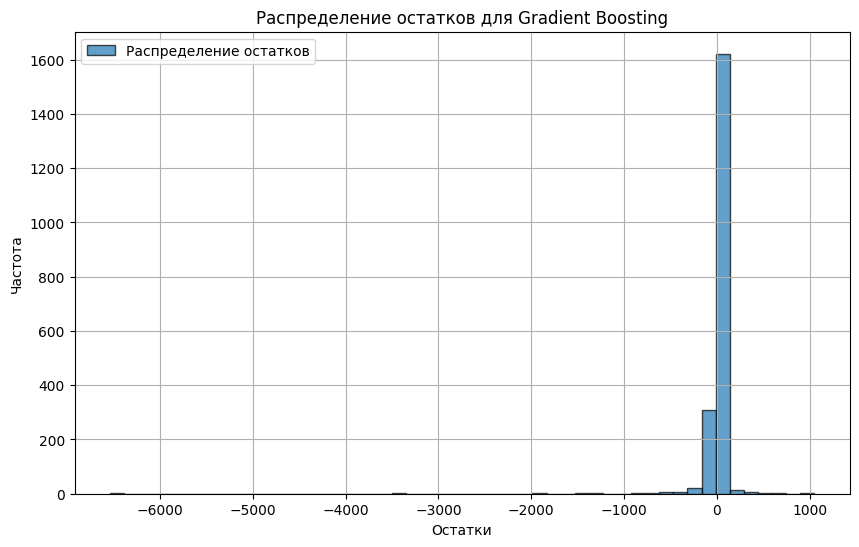

2025-03-05 21:45:26,947 - INFO - Остатки для модели Gradient Boosting сохранены.
2025-03-05 21:45:26,948 - INFO - Анализ остатков для модели: XGBoost...


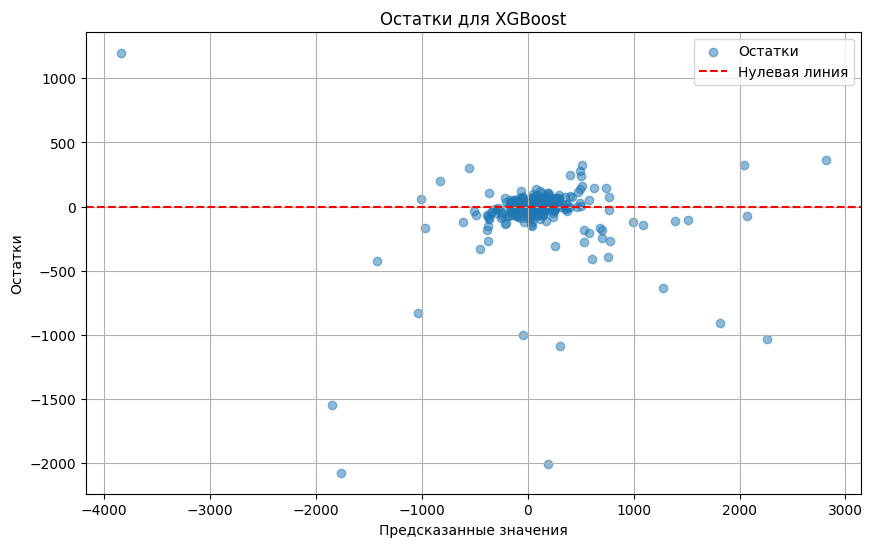

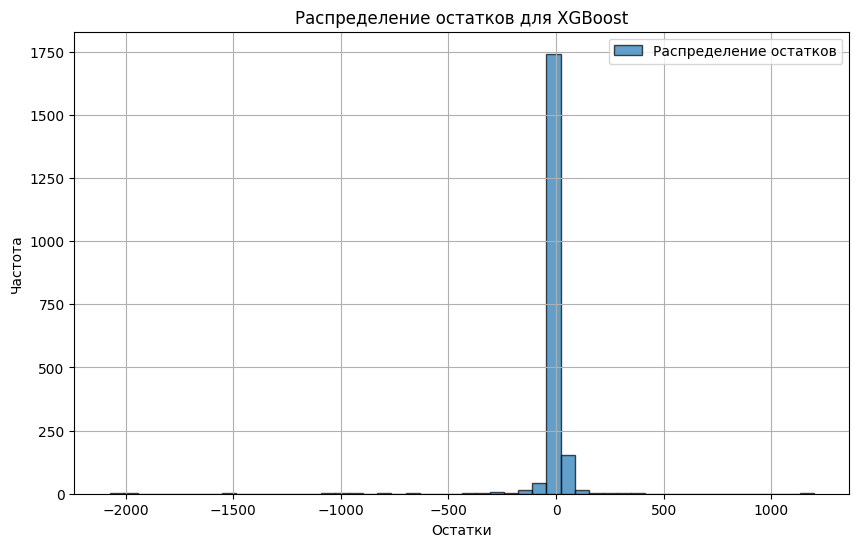

2025-03-05 21:45:27,543 - INFO - Остатки для модели XGBoost сохранены.
2025-03-05 21:45:27,544 - INFO - Анализ остатков для модели: CatBoost...


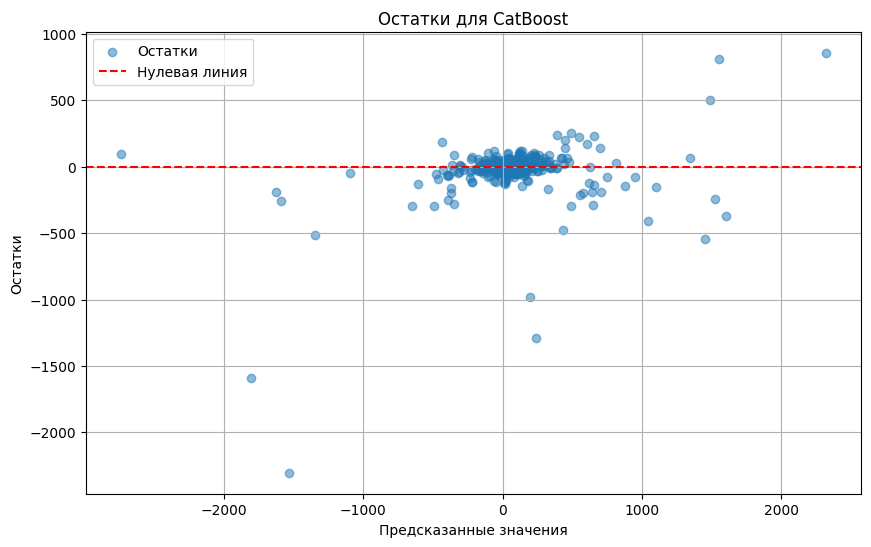

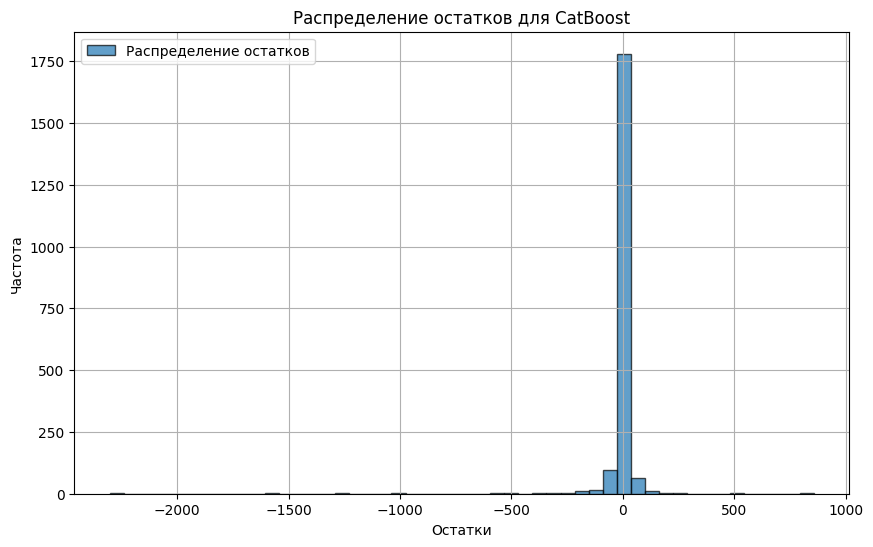

2025-03-05 21:45:31,158 - INFO - Остатки для модели CatBoost сохранены.


In [9]:
import matplotlib.pyplot as plt
import joblib
from utils import load_data, convert_sparse_to_dense
import logging
import numpy as np

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка данных
data_dict = load_data()
X_test = data_dict['X_test']
y_test = data_dict['y_test']

# Преобразование разреженных матриц в плотные массивы (если необходимо)
X_test, _ = convert_sparse_to_dense(X_test, X_test)

# Загрузка всех моделей
models = {
    "Linear Regression": joblib.load('linear_regression_model.joblib'),
    "Random Forest": joblib.load('random_forest_model.joblib'),
    "Gradient Boosting": joblib.load('gradient_boosting_model.joblib'),
    "XGBoost": joblib.load('xgboost_model.joblib'),
    "CatBoost": joblib.load('catboost_model.joblib')
}

# Анализ остатков для всех моделей
for model_name, model in models.items():
    logging.info(f"Анализ остатков для модели: {model_name}...")
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # Визуализация остатков (scatter plot)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5, label='Остатки')
    plt.axhline(y=0, color='r', linestyle='--', label='Нулевая линия')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title(f'Остатки для {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Гистограмма остатков
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7, label='Распределение остатков')
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.title(f'Распределение остатков для {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Сохранение остатков в файл (опционально)
    np.save(f'{model_name.replace(" ", "_").lower()}_residuals.npy', residuals)
    logging.info(f"Остатки для модели {model_name} сохранены.")

2025-03-05 21:34:50,587 - INFO - Анализ важности признаков для модели: Random Forest...


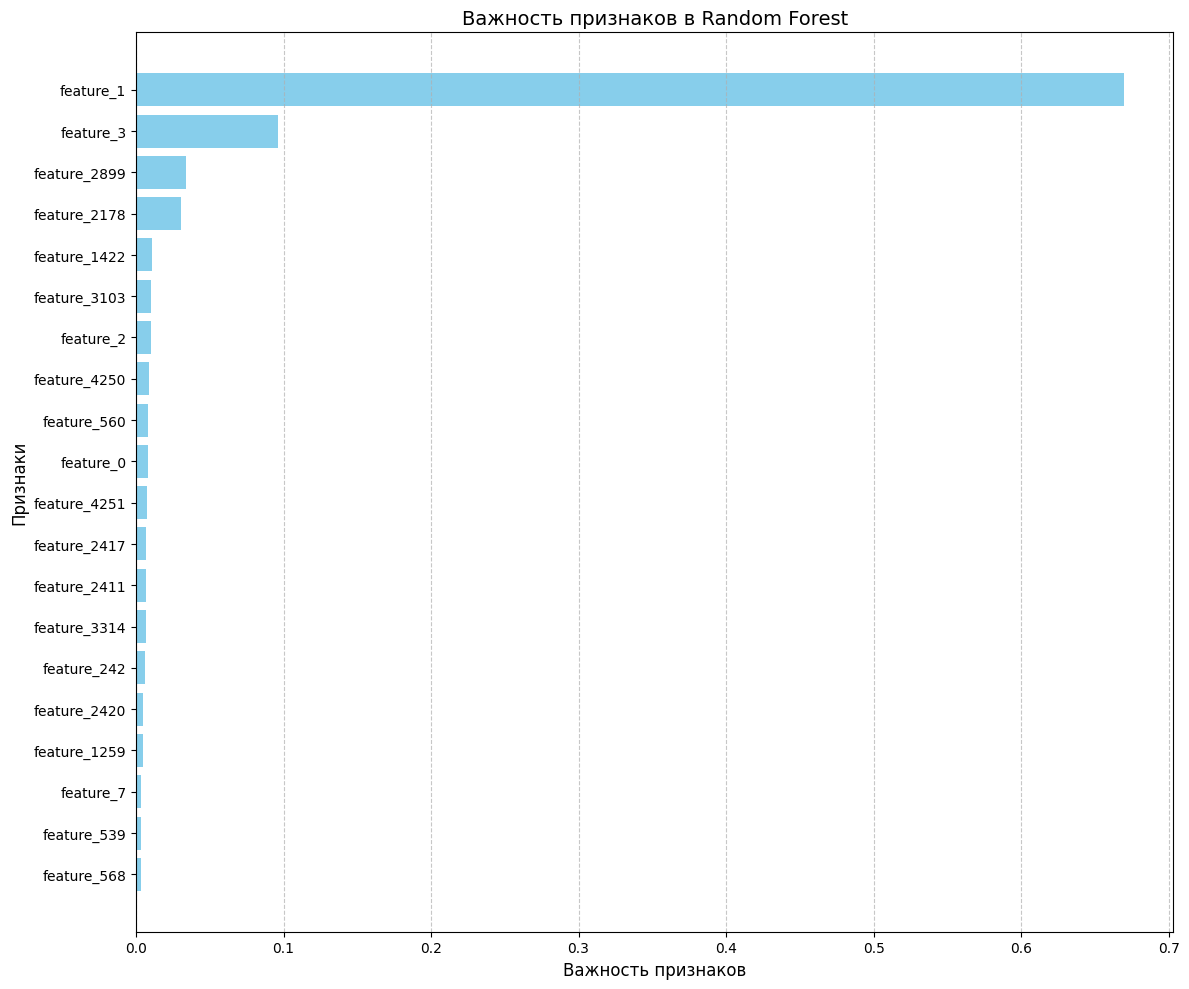

2025-03-05 21:34:51,051 - INFO - График важности признаков для Random Forest сохранен.
2025-03-05 21:34:51,056 - INFO - Анализ важности признаков для модели: Gradient Boosting...


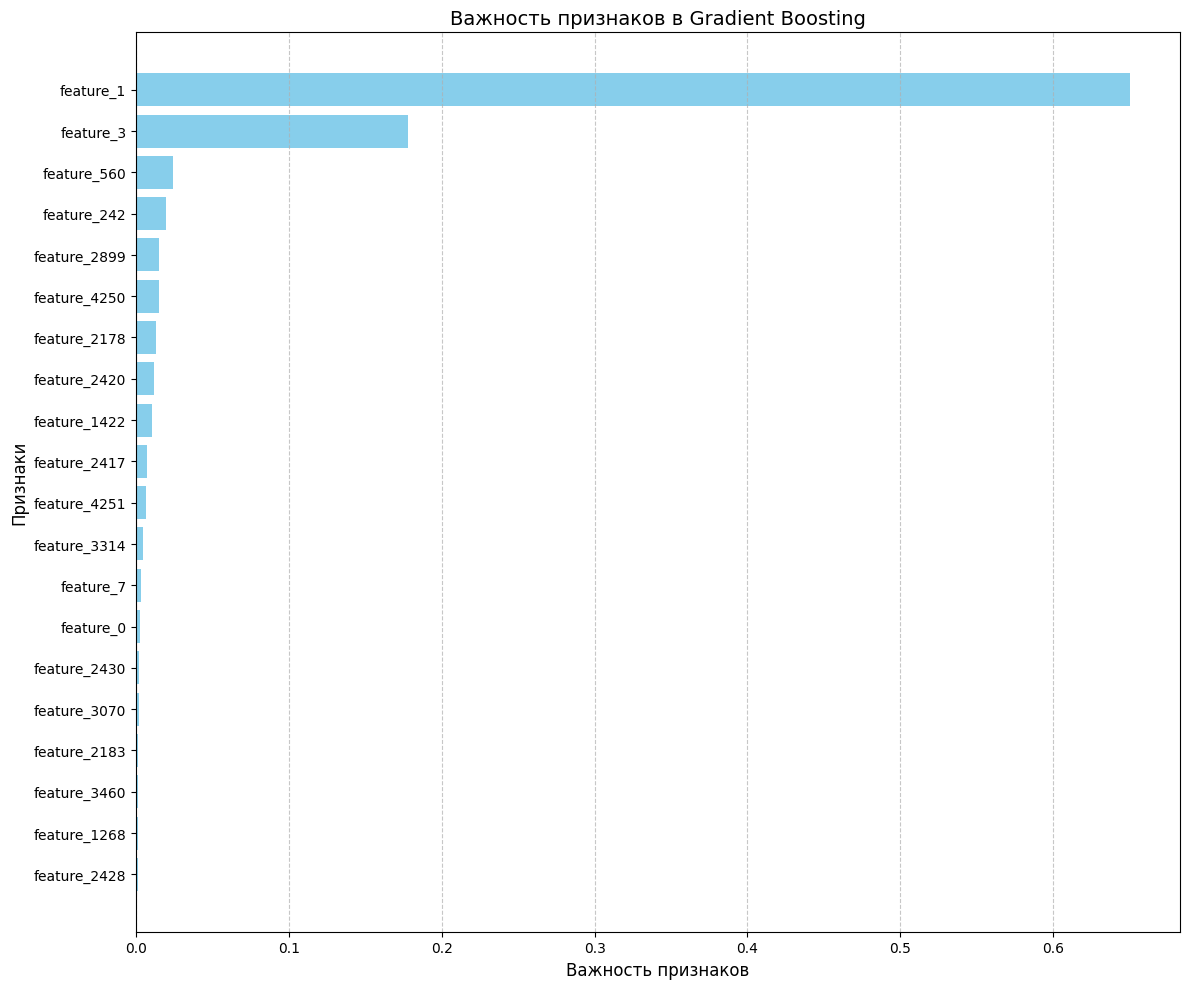

2025-03-05 21:34:51,435 - INFO - График важности признаков для Gradient Boosting сохранен.
2025-03-05 21:34:51,440 - INFO - Анализ важности признаков для модели: XGBoost...


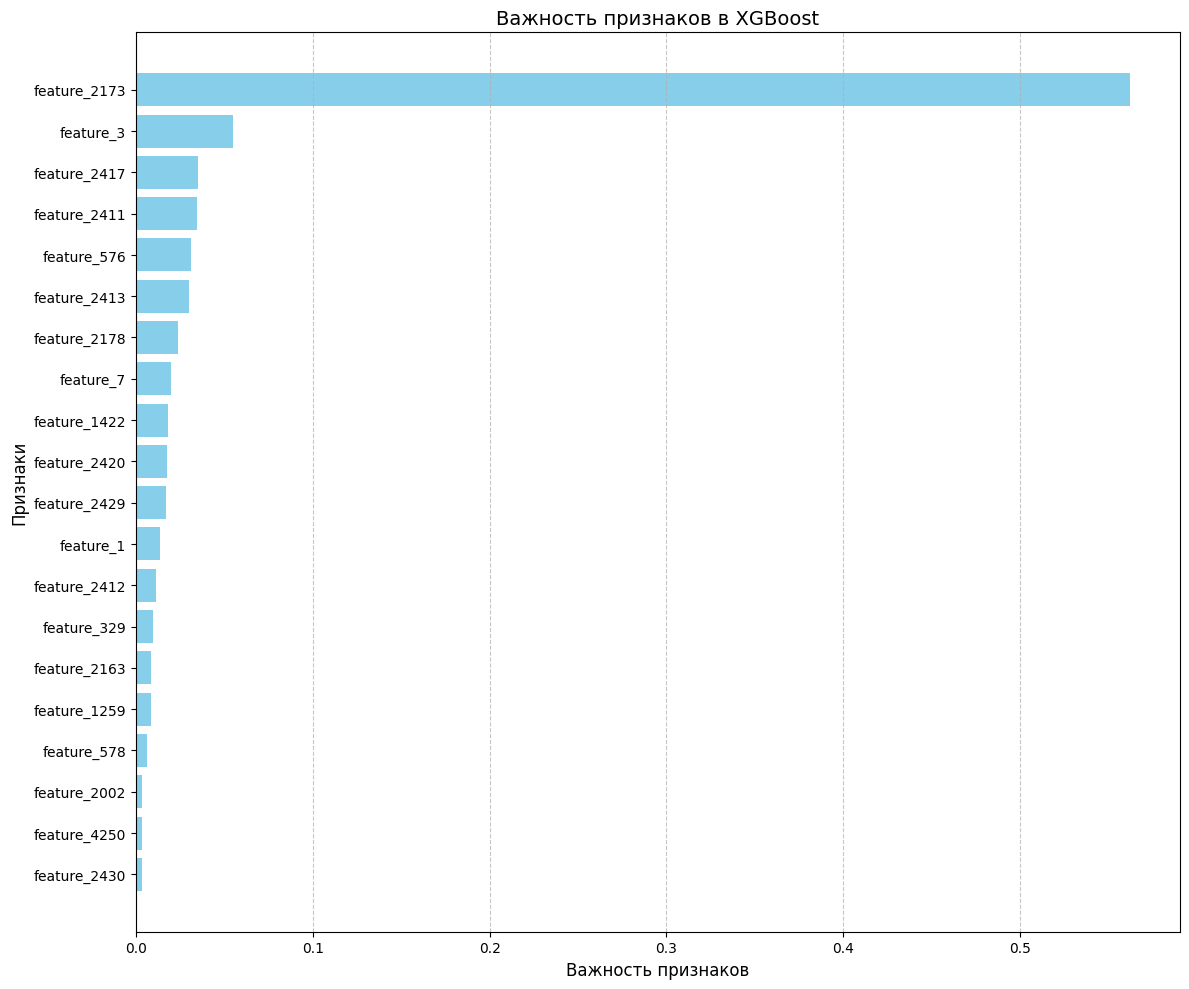

2025-03-05 21:34:51,837 - INFO - График важности признаков для XGBoost сохранен.
2025-03-05 21:34:51,838 - INFO - Анализ важности признаков для модели: CatBoost...


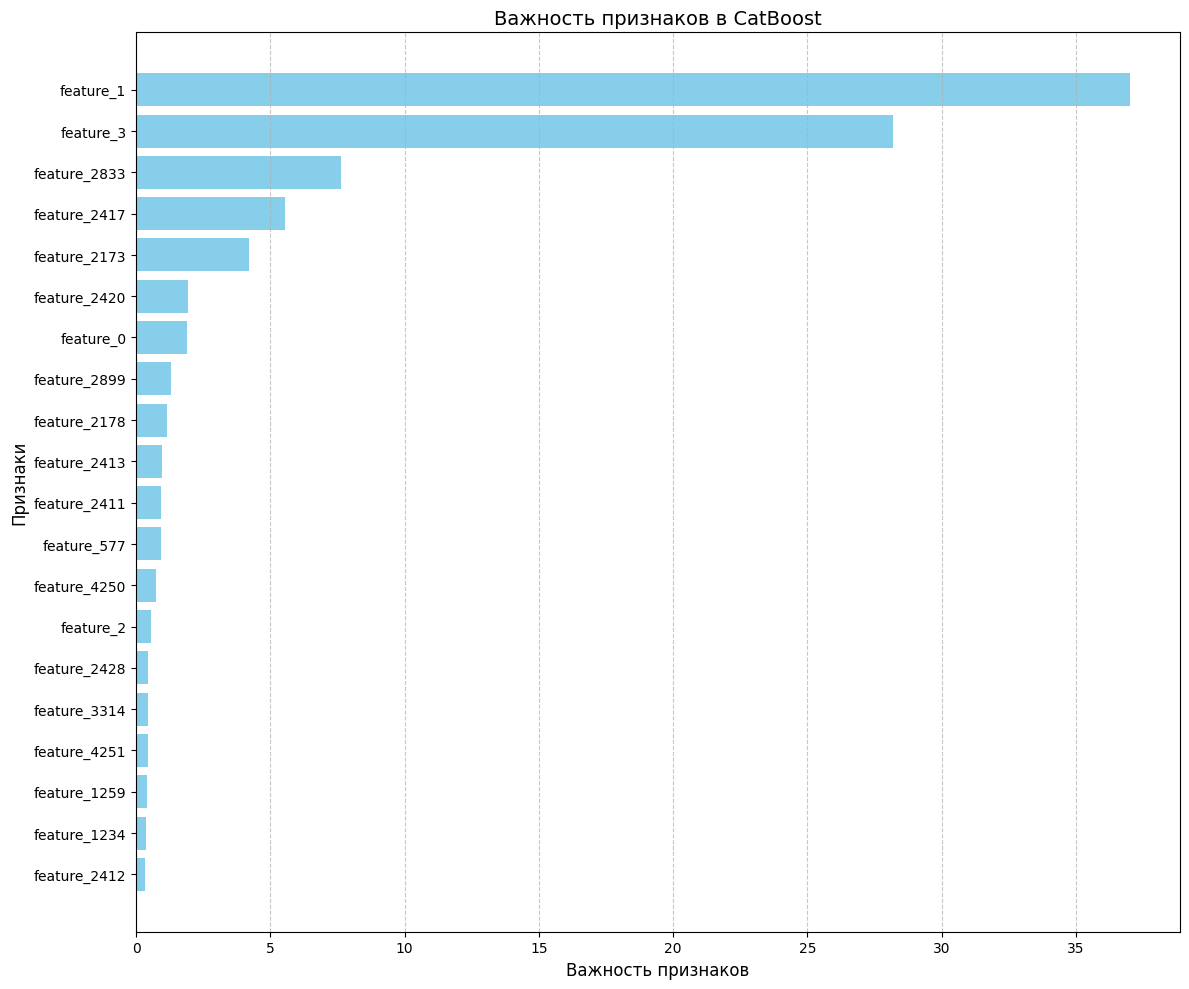

2025-03-05 21:34:52,235 - INFO - График важности признаков для CatBoost сохранен.


In [8]:
import matplotlib.pyplot as plt
import joblib
from utils import load_data, convert_sparse_to_dense
import logging
import numpy as np

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка данных
data_dict = load_data()
X_train = data_dict['X_train']
y_train = data_dict['y_train']

# Преобразование разреженных матриц в плотные массивы (если необходимо)
X_train, _ = convert_sparse_to_dense(X_train, X_train)

# Загрузка всех моделей
models = {
    "Random Forest": joblib.load('random_forest_model.joblib'),
    "Gradient Boosting": joblib.load('gradient_boosting_model.joblib'),
    "XGBoost": joblib.load('xgboost_model.joblib'),
    "CatBoost": joblib.load('catboost_model.joblib')
}

# Визуализация важности признаков
for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        logging.info(f"Анализ важности признаков для модели: {model_name}...")
        feature_importance = model.feature_importances_

        # Получение названий признаков (если доступно)
        try:
            feature_names = model.feature_names_in_
        except AttributeError:
            feature_names = [f"feature_{i}" for i in range(len(feature_importance))]

        # Сортировка признаков по важности
        sorted_idx = np.argsort(feature_importance)[-20:]  # Топ-20 признаков
        sorted_feature_names = [feature_names[i] for i in sorted_idx]
        sorted_importance = feature_importance[sorted_idx]

        # Построение графика
        plt.figure(figsize=(12, 10))  # Увеличенный размер графика
        plt.barh(sorted_feature_names, sorted_importance, align='center', color='skyblue')
        plt.xlabel('Важность признаков', fontsize=12)
        plt.ylabel('Признаки', fontsize=12)
        plt.title(f'Важность признаков в {model_name}', fontsize=14)
        plt.grid(True, axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()  # Улучшение расположения элементов

        # Отображение графика
        plt.show()

        # Сохранение графика в файл (опционально)
        plt.savefig(f'{model_name.replace(" ", "_").lower()}_feature_importance.png', bbox_inches='tight')
        plt.close()  # Закрытие графика для освобождения памяти
        logging.info(f"График важности признаков для {model_name} сохранен.")
    else:
        logging.warning(f"Модель {model_name} не поддерживает атрибут feature_importances_.")

2025-03-05 21:20:49,810 - INFO - Предсказание для модели: Linear Regression...


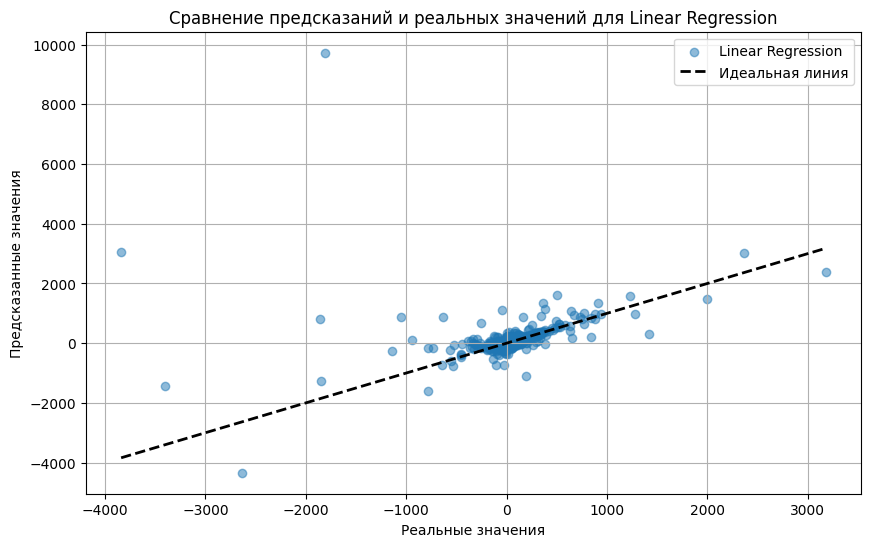

2025-03-05 21:20:50,096 - INFO - График для модели Linear Regression сохранен.
2025-03-05 21:20:50,098 - INFO - Предсказание для модели: Random Forest...


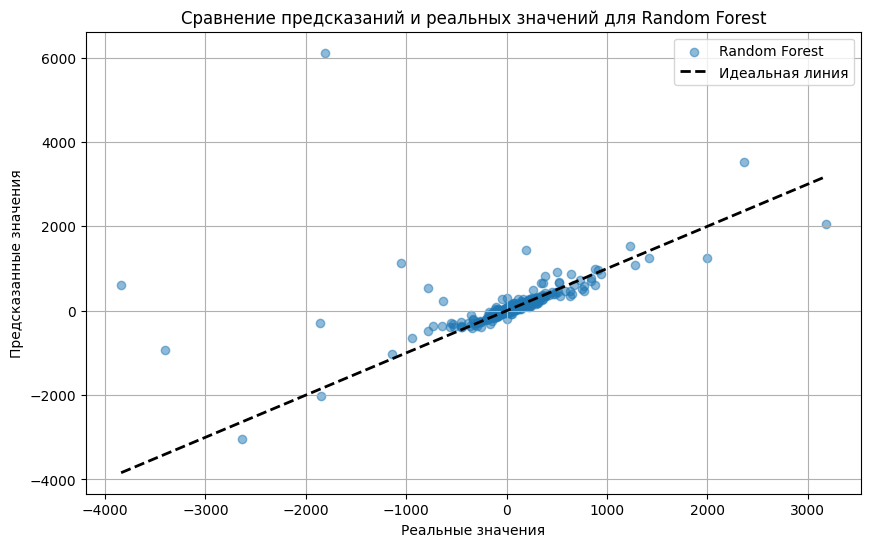

2025-03-05 21:20:50,477 - INFO - График для модели Random Forest сохранен.
2025-03-05 21:20:50,478 - INFO - Предсказание для модели: Gradient Boosting...


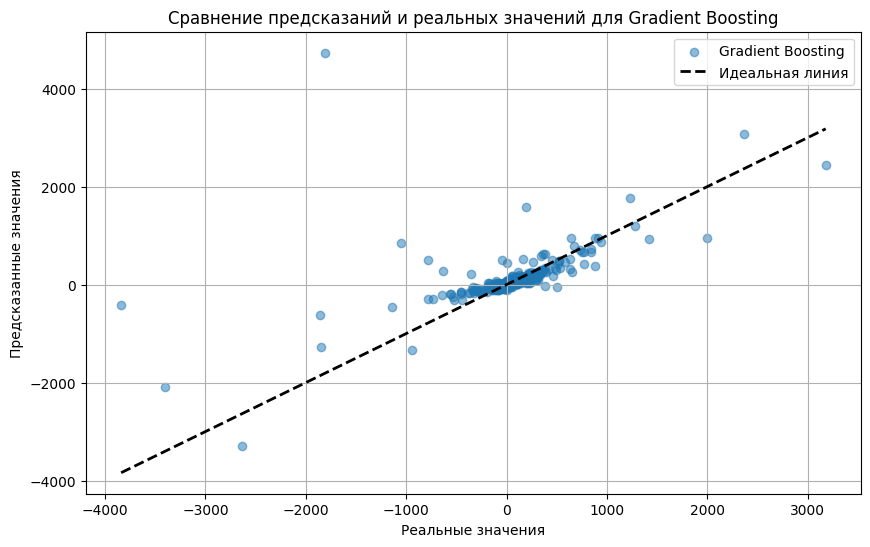

2025-03-05 21:20:50,792 - INFO - График для модели Gradient Boosting сохранен.
2025-03-05 21:20:50,795 - INFO - Предсказание для модели: XGBoost...


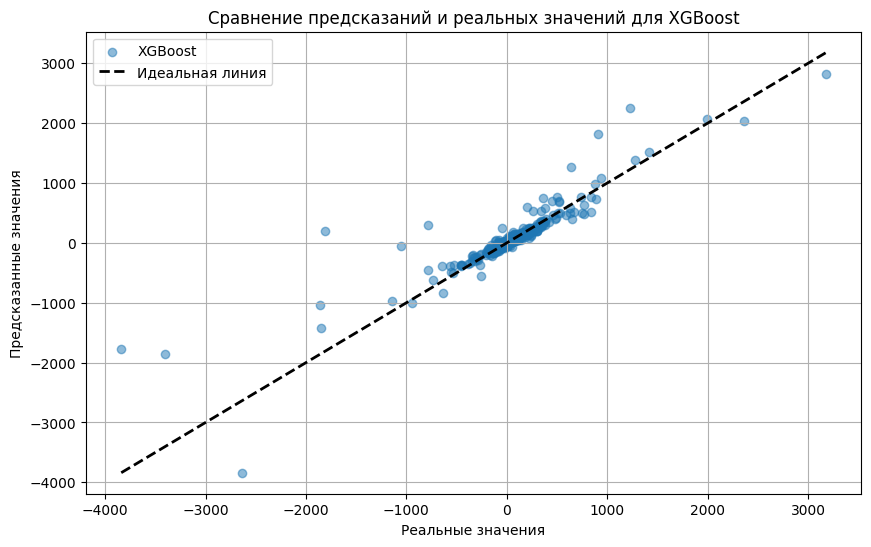

2025-03-05 21:20:51,137 - INFO - График для модели XGBoost сохранен.
2025-03-05 21:20:51,138 - INFO - Предсказание для модели: CatBoost...


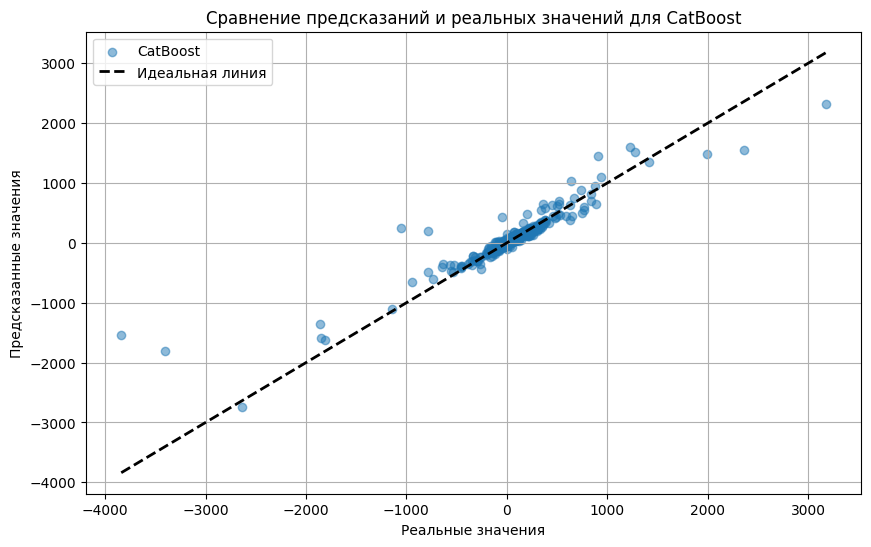

2025-03-05 21:20:54,431 - INFO - График для модели CatBoost сохранен.
2025-03-05 21:20:54,436 - INFO - Визуализация предсказаний завершена.


In [6]:
import matplotlib.pyplot as plt
import joblib
from utils import load_data, convert_sparse_to_dense
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка данных
data_dict = load_data()
X_test = data_dict['X_test']
y_test = data_dict['y_test']

# Преобразование разреженных матриц в плотные массивы (если необходимо)
X_test, _ = convert_sparse_to_dense(X_test, X_test)

# Загрузка всех моделей
models = {
    "Linear Regression": joblib.load('linear_regression_model.joblib'),
    "Random Forest": joblib.load('random_forest_model.joblib'),
    "Gradient Boosting": joblib.load('gradient_boosting_model.joblib'),
    "XGBoost": joblib.load('xgboost_model.joblib'),
    "CatBoost": joblib.load('catboost_model.joblib')
}

# Визуализация предсказаний для каждой модели отдельно
for model_name, model in models.items():
    logging.info(f"Предсказание для модели: {model_name}...")
    y_pred = model.predict(X_test)

    # Создание отдельного графика для каждой модели
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=model_name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Идеальная линия')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Сравнение предсказаний и реальных значений для {model_name}')
    plt.legend()
    plt.grid(True)
    
    # Отображение графика в Jupyter Notebook
    plt.show()
    
    # Сохранение графика в файл (опционально)
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_predictions.png')
    plt.close()  # Закрытие графика для освобождения памяти
    logging.info(f"График для модели {model_name} сохранен.")

logging.info("Визуализация предсказаний завершена.")